##Argimiro Arratia @2023 Computational Finance
##Python Lab: Algorithmic Trading Backtesting with Sentimental indicators
### Note: performance msrs consider transaction costs
###### http://computationalfinance.lsi.upc.edu


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def performance(x, ntrades=1, cost=0):
    """
    Calculates the performance of a stock or portfolio given the returns data.
    
    Parameters:
    x (pd.Series): an array containing the daily returns of the stock or portfolio.
    ntrades (int, optional): the number of trades. Default is 1.
    cost (float, optional): the transaction cost for each trade. Default is 0.
    
    Returns:
    Series: A pandas Series object containing the performance statistics of the stock or portfolio. 
    The Series object has the following indices:
        - Cumulative Return
        - Annual Return
        - Annualized Sharpe Ratio
        - Win %
        - Annualized Volatility
        - Maximum Drawdown
        - Max Length Drawdown
        - n.trades
    """
    cumRetx = np.cumsum(x, axis=0) - ntrades * cost
    annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
    sharpex = annRetx / np.std(x, ddof=1) * np.sqrt(252)
    winpctx = np.count_nonzero(x > 0) / np.count_nonzero(x)
    annSDx = np.std(x, ddof=1) * np.sqrt(252)

    DDs = np.minimum.accumulate(cumRetx) - cumRetx
    maxDDx = DDs.min()
    maxLx = (cumRetx == DDs).argmax()

    Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
    names = np.array(["Cumulative Return", "Annual Return", "Annualized Sharpe Ratio",
    "Win %", "Annualized Volatility", "Maximum Drawdown", "Max Length Drawdown", "n.trades"])
    return pd.Series(Perf, index=names, name=x.name)

In [5]:
def test_MA_strategy(myStock, ts=None, s=5, m=20, longshort=0, tcost=0):
    """
    Calculates the performance of a moving average crossover strategy.

    Parameters:
    myStock (ndarray): an array containing the daily returns of the stock.
    ts (ndarray, optional): an array containing the daily returns of the stock. Default is None.
    s (int, optional): the short window. Default is 5.
    m (int, optional): the long window. Default is 20.
    longshort (int, optional): the long/short strategy. Default is 0. for short use -1
    tcost (float, optional): the transaction cost for each trade. Default is 0.

    Returns:
    DataFrame: A pandas DataFrame object containing the performance statistics of the strategy and the benchmark.
    The DataFrame object has the following columns:
        - MAx: the performance statistics of the strategy.
        - BH: the performance statistics of the benchmark.
    """
    
    if ts is None:
        ts = myStock

    sig = pd.Series(np.where(
        pd.Series(ts).rolling(s).mean() > pd.Series(ts).rolling(m).mean(), 1, longshort
        )).shift(1)
    # Force sig to have the same index as ts
    sig.index = ts.index

    bmkReturns = (myStock / myStock.shift(1) - 1).dropna()
    myReturns = bmkReturns * sig
    myReturns.name = "MAx"
    bmkReturns.name = "BH"

    # Join the returns of the strategy and the benchmark
    tt = pd.concat([myReturns, bmkReturns], axis=1).dropna()

    # Calculate the number of trades
    lruns = np.count_nonzero(np.diff(sig)) + 1
    bhPerf = performance(tt.BH, 2, tcost)
    maxPerf = performance(tt.MAx, lruns, tcost)

    # Plot the performance of the strategy and the benchmark
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(tt.MAx, axis=0), label="MAx")
    plt.plot(np.cumsum(tt.BH, axis=0), label="BH")
    plt.legend()
    plt.show()

    return pd.concat([maxPerf, bhPerf], axis=1)

In [6]:
def rolling_test_MA_strategy(my_stock, ts=None, s=5, m=20, longshort=0, w_size=252):
    """
    Calculates the performance of a moving average crossover strategy.

    Parameters:
    my_stock (ndarray): an array containing the daily returns of the stock.
    ts (ndarray, optional): an array containing the daily returns of the stock. Default is None.
    s (int, optional): the short window. Default is 5.
    m (int, optional): the long window. Default is 20.
    longshort (int, optional): the long/short strategy. Default is 0.
    w_size (int, optional): the window size. Default is 252.

    Returns:
    DataFrame: A pandas DataFrame object containing the performance statistics of the strategy and the benchmark.
    The DataFrame object has the following columns:
        - MAx: the performance statistics of the strategy.
        - BH: the performance statistics of the benchmark.
    """
    if ts is None:
        ts = my_stock

    sig = (pd.Series(np.where(ts.rolling(window=s).mean() > ts.rolling(window=m).mean(), 1, longshort), name='sig')
            .shift(1))
    sig.index = ts.index

    bmk_returns = (my_stock / my_stock.shift(1) - 1).rename("BH")
    my_returns = bmk_returns * sig
    my_returns.rename("Me", inplace=True)
    tt = pd.concat([bmk_returns, my_returns], axis=1).dropna()
    n_windows = int(tt.shape[0] - w_size)
    if n_windows < 1:
        raise ValueError("Window size too large")
    
    perform = []
    for i in range(n_windows):
        bh_stra = tt.iloc[i:w_size+i, 0]
        my_stra = tt.iloc[i:w_size+i, 1]
        perform.append([bh_stra.mean(), my_stra.mean()])
    perform = np.array(perform)
    
    bh_means = perform[:,0].mean()
    me_means = perform[:,1].mean()
    mean_perf = np.array([bh_means, me_means])
    mean_perf = pd.DataFrame(mean_perf, index=["BH", "Me"], columns=["AvgPerf"])
    
    return {"AvgPerf": mean_perf, "NumWindows": n_windows}

In [7]:
# Load and set up data
# frequency of sampling
tau = 1 #data is daily. Try tau=20 (month), tau=60 (quarterly)
x = pd.read_csv('DB.csv', sep = ",")
x = x.iloc[:, 1:]
# x = x.drop(x.columns[[2,3]], axis=1) ##remove ticker and ISIN (non-numerics)
# x = x.drop(x.columns[[0, 8]], axis=1) #for assets CVI, EURUSD
x.head()

,Date,Open,High,Low,Close,Adj Close,Volume,RVT,positivePartscr,negativePartscr,fearPartscr,findownPartscr,finupPartscr,finhypePartscr,certaintyPartscr,uncertaintyPartscr
0,2018-01-02,19.270000,19.330000,19.160000,19.330000,18.801056,2307400,0.0021,0.0021,0.0007,0.0000,0.0007,0.0021,0.0014,0.0007,0.0007
1,2018-01-03,19.090000,19.209999,19.000000,19.160000,18.635706,4235000,0.0021,0.0006,0.0045,0.0000,0.0019,0.0013,0.0013,0.0006,0.0000
2,2018-01-04,19.620001,19.790001,19.620001,19.770000,19.229017,4409500,0.0017,0.0000,0.0030,0.0015,0.0015,0.0030,0.0000,0.0000,0.0015
3,2018-01-05,19.340000,19.400000,18.500000,18.549999,18.042398,16517400,0.0027,0.0048,0.0111,0.0000,0.0134,0.0045,0.0037,0.0026,0.0119
4,2018-01-08,18.330000,18.420000,18.270000,18.299999,17.799240,5030700,0.0016,0.0034,0.0068,0.0000,0.0081,0.0047,0.0020,0.0027,0.0041


In [8]:
# use Date as index
data = pd.DataFrame(x.values[:, 1:], index=pd.to_datetime(x.values[:, 0]), columns=x.columns[1:])
data.head()

,Open,High,Low,Close,Adj Close,Volume,RVT,positivePartscr,negativePartscr,fearPartscr,findownPartscr,finupPartscr,finhypePartscr,certaintyPartscr,uncertaintyPartscr
2018-01-02,19.27,19.33,19.16,19.33,18.801056,2307400,0.0021,0.0021,0.0007,0.0,0.0007,0.0021,0.0014,0.0007,0.0007
2018-01-03,19.09,19.209999,19.0,19.16,18.635706,4235000,0.0021,0.0006,0.0045,0.0,0.0019,0.0013,0.0013,0.0006,0.0
2018-01-04,19.620001,19.790001,19.620001,19.77,19.229017,4409500,0.0017,0.0,0.003,0.0015,0.0015,0.003,0.0,0.0,0.0015
2018-01-05,19.34,19.4,18.5,18.549999,18.042398,16517400,0.0027,0.0048,0.0111,0.0,0.0134,0.0045,0.0037,0.0026,0.0119
2018-01-08,18.33,18.42,18.27,18.299999,17.79924,5030700,0.0016,0.0034,0.0068,0.0,0.0081,0.0047,0.002,0.0027,0.0041


In [9]:
# Transform all columns to float
data = data.astype(float)
data.head()

,Open,High,Low,Close,Adj Close,Volume,RVT,positivePartscr,negativePartscr,fearPartscr,findownPartscr,finupPartscr,finhypePartscr,certaintyPartscr,uncertaintyPartscr
2018-01-02,19.270000,19.330000,19.160000,19.330000,18.801056,2307400.0,0.0021,0.0021,0.0007,0.0000,0.0007,0.0021,0.0014,0.0007,0.0007
2018-01-03,19.090000,19.209999,19.000000,19.160000,18.635706,4235000.0,0.0021,0.0006,0.0045,0.0000,0.0019,0.0013,0.0013,0.0006,0.0000
2018-01-04,19.620001,19.790001,19.620001,19.770000,19.229017,4409500.0,0.0017,0.0000,0.0030,0.0015,0.0015,0.0030,0.0000,0.0000,0.0015
2018-01-05,19.340000,19.400000,18.500000,18.549999,18.042398,16517400.0,0.0027,0.0048,0.0111,0.0000,0.0134,0.0045,0.0037,0.0026,0.0119
2018-01-08,18.330000,18.420000,18.270000,18.299999,17.799240,5030700.0,0.0016,0.0034,0.0068,0.0000,0.0081,0.0047,0.0020,0.0027,0.0041


In [10]:
## Target :  Adj Close Price 
target = data['Adj Close']
target.name = "DB"
target.head()

2018-01-02    18.801056
2018-01-03    18.635706
2018-01-04    19.229017
2018-01-05    18.042398
2018-01-08    17.799240
Name: DB, dtype: float64

## Indicators for use in trade-signals:

In [11]:
# Bearish sentiment indicators
negativeP = data['negativePartscr'].dropna()
negativeP.name = "negative"
uncertaintyP = data['uncertaintyPartscr'].dropna()
findownP = data['findownPartscr'].dropna()

# Bullish sentiment indicators
positiveP = data['positivePartscr'].dropna()
positiveP.name = "positive"
certaintyP = data['certaintyPartscr'].dropna()
finupP = data['finupPartscr'].dropna()

# Combinations
BULL = 0.33*(positiveP + certaintyP + finupP)
BEAR = 0.33*(negativeP + uncertaintyP + findownP)
BULL.name = "BULL"
BEAR.name = "BEAR"

display(BULL.head())
display(BEAR.head())

2018-01-02    0.001617
2018-01-03    0.000825
2018-01-04    0.000990
2018-01-05    0.003927
2018-01-08    0.003564
Name: BULL, dtype: float64

2018-01-02    0.000693
2018-01-03    0.002112
2018-01-04    0.001980
2018-01-05    0.012012
2018-01-08    0.006270
Name: BEAR, dtype: float64

In [12]:
# Bull-Bear ratio: NAs are interpolated with leftmost and rightmost non-NA value
# (NAs can be produced when BULL=BEAR=0)
BULL_BEAR = BULL + BEAR
# Replace 0 with NAN to avoid division by 0
BULL_BEAR[BULL_BEAR == 0] = np.nan
BBr = 100 * BULL / (BULL_BEAR)
BBr.fillna(method='ffill', inplace=True)
BBr.fillna(method='bfill', inplace=True)
BBr.name = "BBr"

# BBlog = 0.5*np.log((BULL + 1) / (BEAR + 1))

BBr.head()

2018-01-02    70.000000
2018-01-03    28.089888
2018-01-04    33.333333
2018-01-05    24.637681
2018-01-08    36.241611
Name: BBr, dtype: float64

In [13]:
# pos_negP = positiveP + negativeP
# # Replace 0 with NAN to avoid division by 0
# pos_negP[pos_negP == 0] = np.nan
# PNr = 100 * positiveP / (positiveP + negativeP)
# PNr.fillna(method='ffill', inplace=True)
# PNr.fillna(method='bfill', inplace=True)
# PNr.name = "PNr"

PNlog = 0.5 * np.log((positiveP + 1) / (negativeP + 1))
PNlog.name = "PNr"

## Test Performance of Trading strategy against BH MA crossover strategy: parameters s<m (short-long periods)

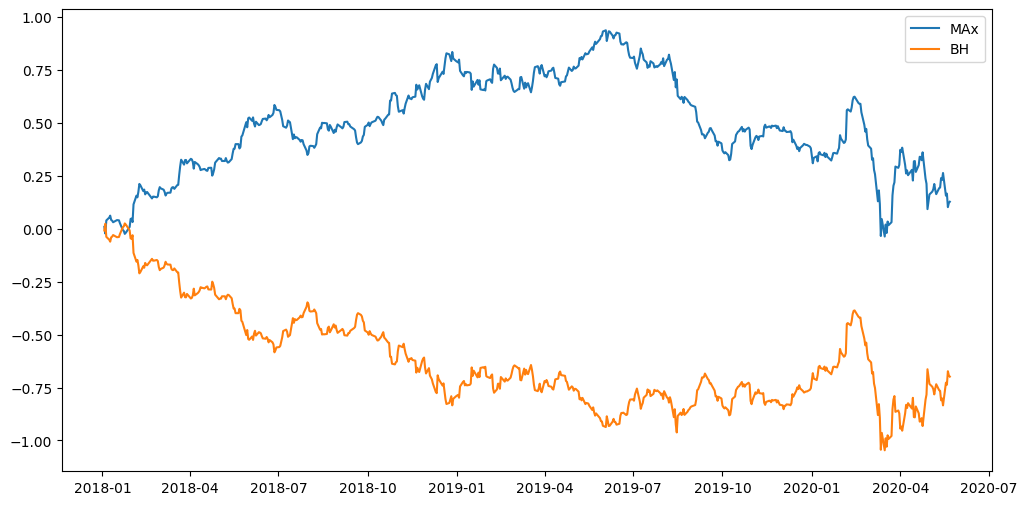

,MAx,BH
Cumulative Return,-0.372980,-0.798544
Annual Return,-0.177758,-0.489211
Annualized Sharpe Ratio,-98.819197,-272.181100
Win %,0.521295,0.480409
Annualized Volatility,0.453302,0.452938
Maximum Drawdown,-0.961073,-0.575788
Max Length Drawdown,0.000000,0.000000
n.trades,10.000000,2.000000


In [20]:
# Rule: MA(s)>MA(m) buy, else sell

# the explanatory variable
ev = BEAR  #PNlog #BBr; #positiveP;   #negativeP;  BEAR; PNr

# Run tests for ev = {positiveP,negativeP,BULL,BEAR,BBr,PNr}
# (s,m) = {5,10,15,20}x{25,50,100}

# Full period test. Tune s, m, longshort=0,-1

res = test_MA_strategy(target, target, s=30, m=100, longshort=-1, tcost=0.05)
res

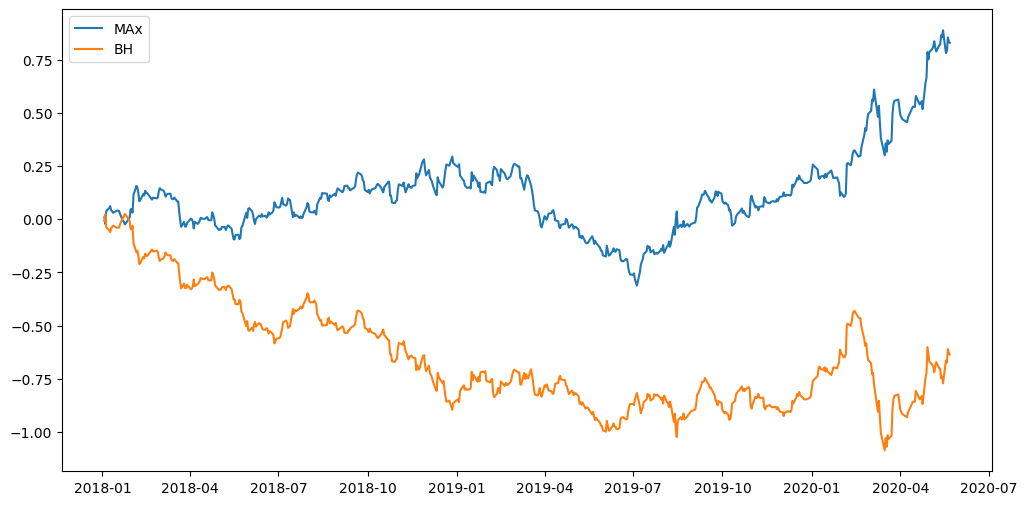

,MAx,BH
Cumulative Return,0.138330,-0.655446
Annual Return,0.057601,-0.369071
Annualized Sharpe Ratio,32.867455,-210.481697
Win %,0.492091,0.479789
Annualized Volatility,0.441634,0.441871
Maximum Drawdown,-1.198877,-0.592179
Max Length Drawdown,0.000000,0.000000
n.trades,69.000000,2.000000


In [17]:
res = test_MA_strategy(target, ev, s=10, m=25, longshort=-1, tcost=0.01)
res

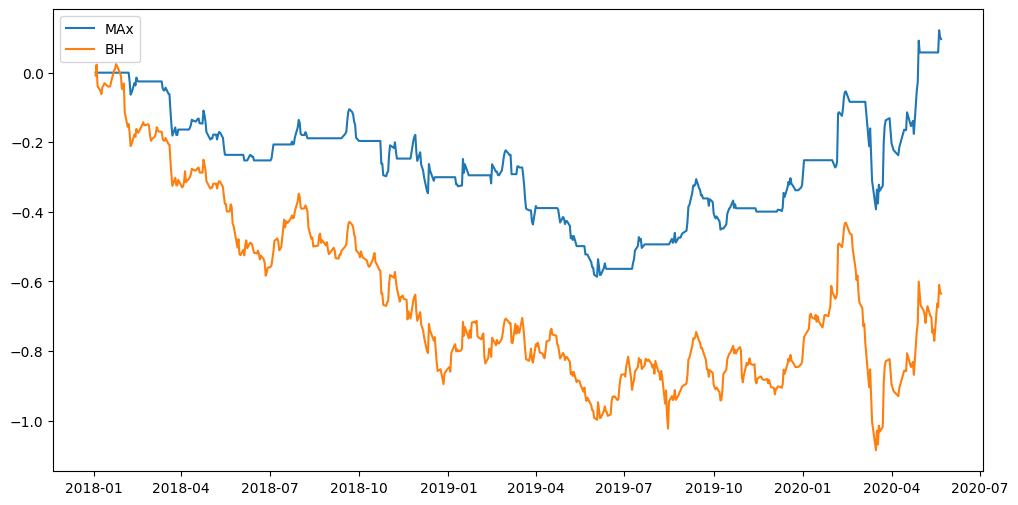

,MAx,BH
Cumulative Return,-0.593558,-0.655446
Annual Return,-0.322373,-0.369071
Annualized Sharpe Ratio,-240.830271,-210.481697
Win %,0.470588,0.479789
Annualized Volatility,0.337325,0.441871
Maximum Drawdown,-0.708577,-0.592179
Max Length Drawdown,0.000000,0.000000
n.trades,69.000000,2.000000


In [19]:
res = test_MA_strategy(target, ev, s=10, m=25, longshort=0, tcost=0.01)
res

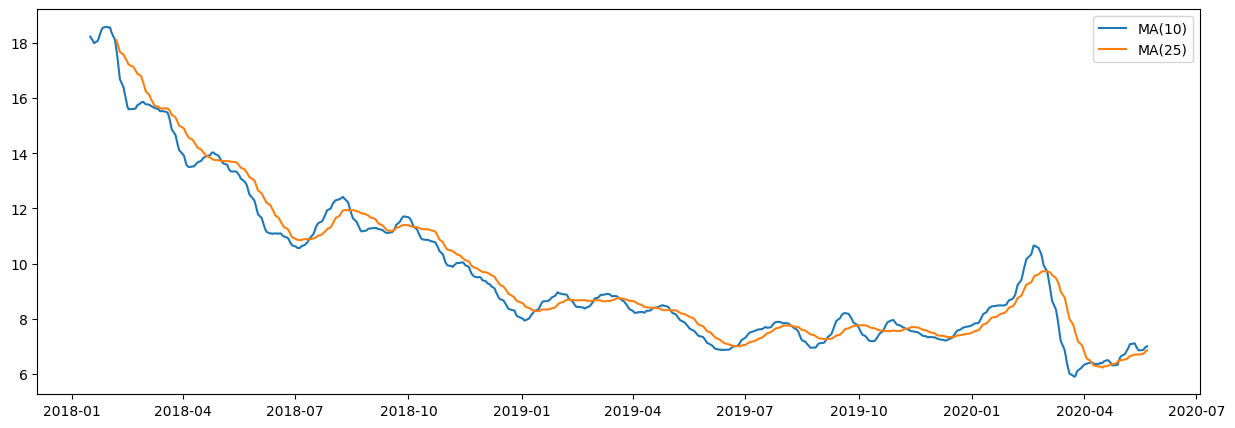

In [ ]:
# Plot the MA(10) blue, MA(25) red, crossover for price (change to ev)
plt.figure(figsize=(15, 5))
plt.plot(target.index, target.rolling(window=10).mean(), label='MA(10)')
plt.plot(target.index, target.rolling(window=25).mean(), label='MA(25)')
# plt.plot(target.index, target, label='Price')
plt.legend(loc='best')
plt.show()

In [18]:
# Average Performance of MA crossover over fixed length periods (window_size= 1 yr, 6 mon) 
# using Rolling windows. Window size 252 (a year of daily data) or 252/2 for 6 mon
# Number of windows = full_period - window_size

manperf = rolling_test_MA_strategy(target, ev, s=10, m=25, longshort=-1,  w_size=252//2)
manperf

{'AvgPerf':      AvgPerf
 BH -0.001090
 Me  0.000676,
 'NumWindows': 457}